In [1]:
import json
import subprocess
import sys
import math
import numpy
import re
import matplotlib.pyplot as plt
import time




In [2]:
type_variables = {
    "juvenile_concentration": float,
    "birth_rate": float,
    "maturity_rate": float,
    "death_rate_juvenile": float,
    "death_rate_susceptible": float,
    "death_rate_over_population": float,
    "infection_rate_infected": float,
    "infection_rate_diseased": float,
    "incubation": float,
    "progression": float,
    "death_rate_infected": float,
    "death_rate_diseased": float,
    "DFTD_start": float,
}

## Read in observed data

In [3]:
import pandas as pd
import numpy as np# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
carry_cap = int(max(devil_pop)*1.16)


In [4]:
mean_std_db={}

In [5]:
sweeps={}

In [6]:
def setup_sweep():
    for name,v in type_variables.items():
        sweeps[name] =[ variables[name] ]
        
        sweeps[name].insert(0, variables[name]*0.975  )
        sweeps[name].insert(0, variables[name]*0.95  )
        sweeps[name].insert(0, variables[name]*0.9  )
        sweeps[name].insert(0, variables[name]*0.85  )
        sweeps[name].insert(0, variables[name]*0.8  )
        
        sweeps[name].append(variables[name]*1.025  )
        sweeps[name].append(variables[name]*1.05  )
        sweeps[name].append(variables[name]*1.1  )
        sweeps[name].append(variables[name]*1.15  )
        sweeps[name].append(variables[name]*1.2  )
            
        sweeps[name] = sorted(list(set(sweeps[name])))
        for n,x in enumerate(sweeps[name]):
            if type_variables[name]==int:
                x = str(x)
            else:
                x = f"{x:.4e}"
            if '00000' in x:
                x=re.sub(r"00000\d+",'',x)
            elif '99999' in x:
                x=re.sub(r"99999\d+",'9',x)
            sweeps[name][n]=x


In [7]:
def compress_vars(var,sweeps):
    ret=''
    for k,v in var.items():
        ret += f" {k}={v}"
    for k,v in sweeps.items():
        ret += f" SWEEP_{k}="
        for vv in v:
            ret+=f"{vv},"
    return ret

In [8]:
def run_remote(var, sweeps):
    server = "brian@james.cs.unca.edu"
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    cmd = "run_parameter_sweep.py"
    full_cmd = f"ssh {server} \"{cmdpath}{cmd} {compress_vars(var,sweeps)}\" "
    print(full_cmd)
    p=subprocess.run(full_cmd, shell=True, capture_output=True)
    print(p.stdout.decode())
    print(p.stderr.decode())


In [9]:
# def make_filename(variables):
#     cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
#     ret = cmdpath+'/ps-'
#     for k in sorted(variables.keys()):
#         if k in type_variables and type_variables[k]==int:
#             x = str(variables[k])
#         else:
#             x = f"{variables[k]:.4e}"
#         ret+=f"{x},"
#     return ret
def make_filename(variables):
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    ret = cmdpath+'/ps-'
    for k in sorted(variables.keys()):
        v = float(variables[k])
        x = f"{v:.4e}"
        ret+=f"{x},"
    return ret


In [10]:
def get_mean_std(var):
    f = make_filename(var)
    if f in mean_std_db:
        return mean_std_db[f]
    
    server = "brian@james.cs.unca.edu"
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    full_cmd = f"ssh {server} \"cat {f}.m\" "
    #print(full_cmd)
    time.sleep(0.1)
    p=subprocess.run(full_cmd, shell=True, capture_output=True)
    try:
        resp = p.stdout.decode()
        (m,s) = resp.split(",",2)
        mean_std_db[f] = (float(m),float(s))
        return (float(m),float(s))
    except Exception as e:
        time.sleep(0.2)
        #print(f"{full_cmd}: Caught e={e}")
        #print(p.stdout.decode())
        #print(p.stderr.decode())
        raise e


In [11]:

def plot_eresult(eresults): 
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
    fig, ax1 = plt.subplots(figsize=[12, 6])

    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
    ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
    ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
    ax1.text(variables['DFTD_start']-7, 24000, dates[int(variables['DFTD_start'])], rotation="vertical", color="black", fontsize=14)
    #ax1.set_xlim([0, result[0]['time'][-1]])
    #ax1.set_ylim([-3000, max(devil_pop)*1.25])
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_yticks([20000,40000,60000])
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.set_ylim([0, carry_cap])
    ax1.set_xlim(0,eresults[0]['time'][-1])
    for n,r in enumerate(eresults):
        if n==0: continue
        ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
        ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

#     ax2 = plt.axes([0,0,1,1])
#     # Manually set the position and relative size of the inset axes within ax1
#     ip = InsetPosition(ax1, [0.25,0.55,0.175,0.25])
#     ax2.set_axes_locator(ip)
#     # Mark the region corresponding to the inset axes on ax1 and draw lines
#     # in grey linking the two axes.
#     mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

#     # plot in the inset
#     inst=155
#     ined=inst+31
#     #ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
#     #ax2.plot(eresults[0]['time'][inst:ined], eresults[0]['Devils'][inst:ined],'b', label="Simulation")
#     ax2.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
#     ax2.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
#     ax2.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
#     ax2.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
#     ax2.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
#     for n,r in enumerate(eresults):
#         if n==0: continue
#         #ax2.plot(eresults[n]['time'][inst:ined], eresults[n]['Devils'][inst:ined],'b', alpha=0.05)
#         ax2.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
#         ax2.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
#         ax2.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
#         ax2.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
#         ax2.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
#         ax2.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')
        
#     ax2.set_xlim(inst,ined-1)
#     ax2.set_ylim(2000,7000)
#     #ax2.set_yticks([49000,54000])
#     ax2.tick_params(axis='y', labelrotation=90)

    #plt.tight_layout()
    #plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")
    print(variables)
    
    def calculate_distance(eresults):
        '''return mean/stddev of L2 norm distance'''
        global obs
        dists = np.zeros(len(eresults))
        for n,r in enumerate(eresults):
            dists[n] = np.linalg.norm(r['Devils']-obs[0][0],2)
        return np.average(dists), np.std(dists)

    dist_l2 = calculate_distance(eresults)
    print(f"L2 = {dist_l2[0]:.2f} +/-{dist_l2[1]:.2f}")



In [12]:
def plot_sweep(name):
    xvals = numpy.zeros(len(sweeps[name]))
    mvals = numpy.zeros(len(sweeps[name]))
    svals = numpy.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = type_variables[name](v)
        keepgoing=True
        while keepgoing:
            try:
                (m,s) = get_mean_std(c)
                xvals[n]=c[name]
                mvals[n]=m
                svals[n]=s
                keepgoing=False
            except Exception as e:
                print(f"caught e={e} while name={name} ")
                time.sleep(1)
    
    plt.figure(figsize=[12, 6])
    plt.errorbar(xvals,mvals,yerr=svals, capsize=10)
    plt.plot([variables[name], variables[name]],[0, max(mvals)],'--')
    plt.xlabel(name, fontsize=12)
    plt.ylabel('Error', fontsize=12)

In [13]:
def plot_sweep2(name,nr,nc,np):
    global pltcnt
    xvals = numpy.zeros(len(sweeps[name]))
    mvals = numpy.zeros(len(sweeps[name]))
    svals = numpy.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = type_variables[name](v)
        try:
            (m,s) = get_mean_std(c)
            xvals[n]=c[name]
            mvals[n]=m
            svals[n]=s
        except Exception as e:
            print(f"caught e={e} while name={name} ")
    
    plt.subplot(nr,nc,np)
    plt.errorbar(xvals,mvals,yerr=svals, capsize=10)
    plt.plot([variables[name], variables[name]],[40000, 100000],'--')
    plt.xlabel(name, fontsize=12)
    plt.ylabel('Error', fontsize=12)


# Run Parameter Sweep

In [14]:
# orig values
# variables = {
#     "juvenile_concentration": 0.467,
#     "infected_concentration": 5e-5,
#     "birth_rate": 0.055,
#     "maturity_rate": 0.04267,
#     "infection_rate_infected": 2e-05,
#     "infection_rate_diseased": 3e-05,
#     "incubation": 22.6,
#     "progression": 12,
#     "death_rate_juvenile": 0.006,
#     "death_rate_susceptible": 0.02335,
#     "death_rate_over_population": 2.3e-7,
#     "death_rate_infected": 0.03,
#     "death_rate_diseased": 0.048,
#     "DFTD_start": 40
# }

# values from SCIOPE - changed base params
# variables = {
#     'DFTD_start': 115, 
#     'birth_rate': 0.05368770371252766, 
#     'death_rate_diseased': 0.29134996217062514, 
#     'death_rate_infected': 0.020695079156445997, 
#     'death_rate_juvenile': 0.0050507985678769326, 
#     'death_rate_over_population': 2.4123665653215824e-07, 
#     'death_rate_susceptible': 0.01874946791275728, 
#     'incubation': 10.99687624550675, 
#     'infection_rate_diseased': 4.978182435648742e-05, 
#     'infection_rate_infected': 1.4809664001475363e-05, 
#     'juvenile_concentration': 0.49534348836011316, 
#     'maturity_rate': 0.04167,#0.03252945608226684, 
#     'progression': 10.746230534983676
# }


# variables = {
#     'juvenile_concentration': 0.49534348836011316, 
#     'birth_rate': 0.055, 
#     'maturity_rate': 0.04,#0.04167,
#     'death_rate_juvenile': 0.007,#0.006, 
#     'death_rate_over_population': 2.3e-07, 
#     'death_rate_susceptible': 0.02335, 
#     'incubation': 10.25,#10, #10.99687624550675, 
#     'progression': 10.74,#11.015,#10.746230534983676,
#     'infection_rate_diseased': 3.84e-05,#3.2e-05, #3.4e-05 #3e-05, #4.978182435648742e-05, 
#     'infection_rate_infected': 1e-05,#1.0698e-05,#1.1261e-05,#1.155e-05,#1.1e-05, #1.2e-05 #1e-5, #1.4809664001475363e-05, 
#     'death_rate_diseased': 0.29017,#0.25232,#0.22938,#0.23526,#0.27678,#0.29134996217062514, 
#     'death_rate_infected': 0.022609,#0.01966,#0.020695079156445997, 
#     'DFTD_start': 100,#97,#95, #105, 
# }

variables = {'DFTD_start': 92.77935556132876, 
 'birth_rate': 0.06752545559096416, 
 'death_rate_diseased': 0.26652318495948685, 
 'death_rate_infected': 0.026874850246323214, 
 'death_rate_juvenile': 0.008626490086993014, 
 'death_rate_over_population': 2.691054479103682e-07, 
 'death_rate_susceptible': 0.021134296008419064, 
 'incubation': 12.172499624073005, 
 'infection_rate_diseased': 4.417483587945668e-05, 
 'infection_rate_infected': 7.542254313029466e-06, 
 'juvenile_concentration': 0.43955619317374217, 
 'maturity_rate': 0.04000000000000001, 
 'progression': 11.875637959748653}



variables_orig = variables.copy()


In [15]:
setup_sweep()

In [16]:
#sweeps['DFTD_start']=['1.0358e+02', '1.0933e+02', '1.1221e+02', '1.1508e+02', '1.2084e+02', '1.2659e+02', '1.3235e+02', '1.3522e+02']
sweeps['DFTD_start']=['85','90','92','94','96','98','100','102','104','106','108','110','115']

In [17]:
print(sweeps)

{'juvenile_concentration': ['3.1364e-01', '3.3324e-01', '3.5285e-01', '3.7245e-01', '3.8225e-01', '3.9205e-01', '4.0185e-01', '4.1166e-01', '4.3126e-01', '4.5086e-01', '4.7046e-01'], 'birth_rate': ['4.6776e-02', '4.9700e-02', '5.2623e-02', '5.5547e-02', '5.7008e-02', '5.8470e-02', '5.9932e-02', '6.1394e-02', '6.4317e-02', '6.7241e-02', '7.0164e-02'], 'maturity_rate': ['3.3336e-02', '3.5419e-02', '3.7503e-02', '3.9586e-02', '4.0628e-02', '4.1670e-02', '4.2712e-02', '4.3754e-02', '4.5837e-02', '4.7920e-02', '5.0004e-02'], 'death_rate_juvenile': ['5.6462e-03', '5.9991e-03', '6.3519e-03', '6.7048e-03', '6.8813e-03', '7.0577e-03', '7.2342e-03', '7.4106e-03', '7.7635e-03', '8.1164e-03', '8.4693e-03'], 'death_rate_susceptible': ['2.1419e-02', '2.2757e-02', '2.4096e-02', '2.5435e-02', '2.6104e-02', '2.6773e-02', '2.7443e-02', '2.8112e-02', '2.9451e-02', '3.0789e-02', '3.2128e-02'], 'death_rate_over_population': ['1.6175e-07', '1.7186e-07', '1.8197e-07', '1.9208e-07', '1.9714e-07', '2.0219e-07'

In [18]:
variables

{'DFTD_start': 103.91242512228831,
 'birth_rate': 0.05847025317854839,
 'death_rate_diseased': 0.23915331103217033,
 'death_rate_infected': 0.023814006049944304,
 'death_rate_juvenile': 0.007057714094206419,
 'death_rate_over_population': 2.0219273791008782e-07,
 'death_rate_susceptible': 0.026773380233574125,
 'incubation': 9.434483161520545,
 'infection_rate_diseased': 3.6702362283180535e-05,
 'infection_rate_infected': 9.530836628131594e-06,
 'juvenile_concentration': 0.39205283390872614,
 'maturity_rate': 0.04167,
 'progression': 9.658348217046363}

In [19]:
%time run_remote(var=variables, sweeps=sweeps)

ssh brian@james.cs.unca.edu "/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/run_parameter_sweep.py  DFTD_start=103.91242512228831 birth_rate=0.05847025317854839 death_rate_diseased=0.23915331103217033 death_rate_infected=0.023814006049944304 death_rate_juvenile=0.007057714094206419 death_rate_over_population=2.0219273791008782e-07 death_rate_susceptible=0.026773380233574125 incubation=9.434483161520545 infection_rate_diseased=3.6702362283180535e-05 infection_rate_infected=9.530836628131594e-06 juvenile_concentration=0.39205283390872614 maturity_rate=0.04167 progression=9.658348217046363 SWEEP_juvenile_concentration=3.1364e-01,3.3324e-01,3.5285e-01,3.7245e-01,3.8225e-01,3.9205e-01,4.0185e-01,4.1166e-01,4.3126e-01,4.5086e-01,4.7046e-01, SWEEP_birth_rate=4.6776e-02,4.9700e-02,5.2623e-02,5.5547e-02,5.7008e-02,5.8470e-02,5.9932e-02,6.1394e-02,6.4317e-02,6.7241e-02,7.0164e-02, SWEEP_maturity_rate=3.3336e-02,3.5419e-02,3.7503e-02,3.9586e-02,4.0628e-02,4.1670e-02,4.2712e-02,4.3

caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (expected 2, got 1) while name=birth_rate 
caught e=not enough values to unpack (ex

caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values to unpack (expected 2, got 1) while name=progression 
caught e=not enough values t

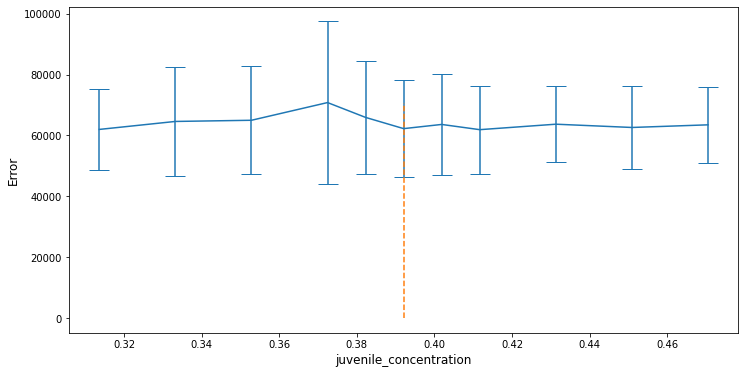

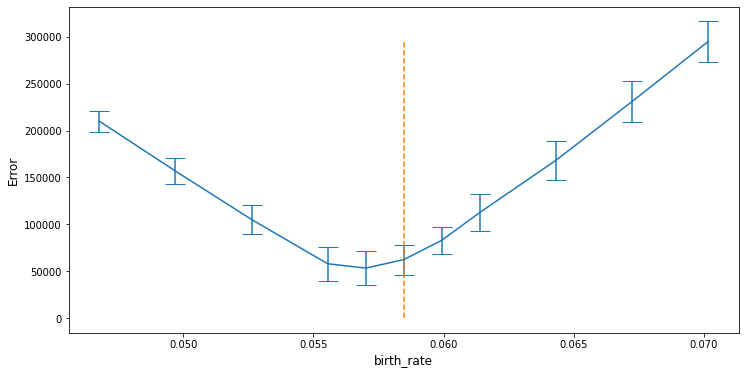

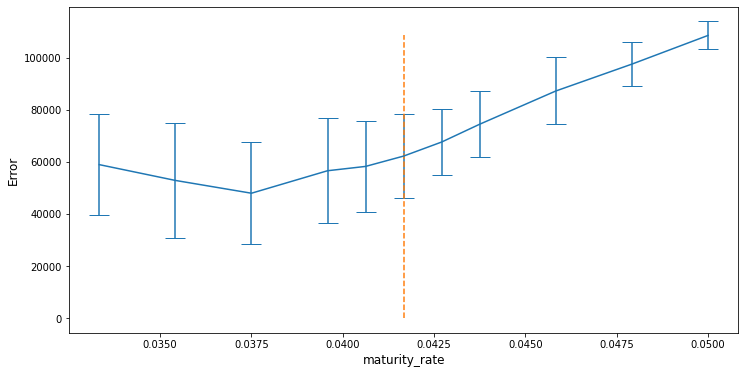

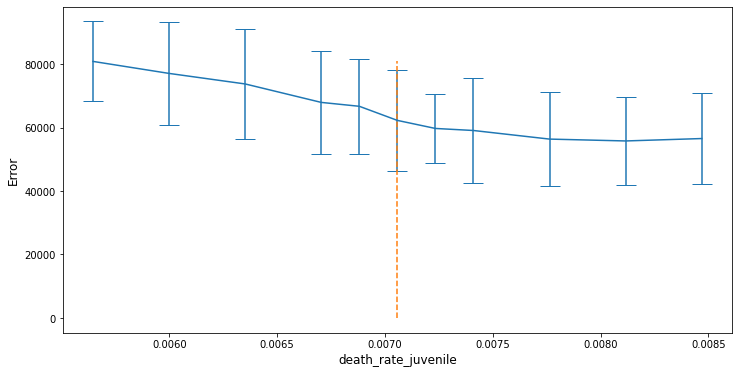

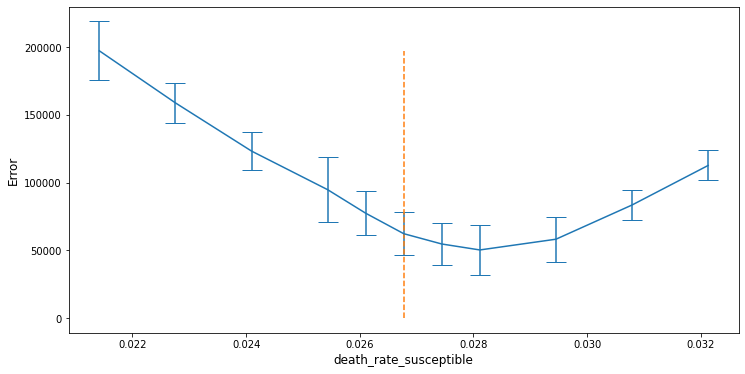

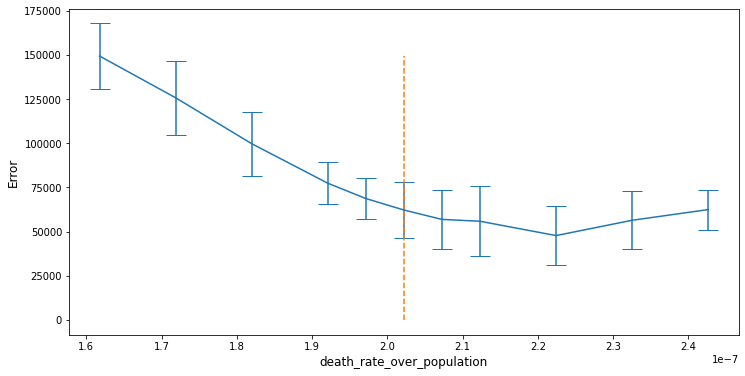

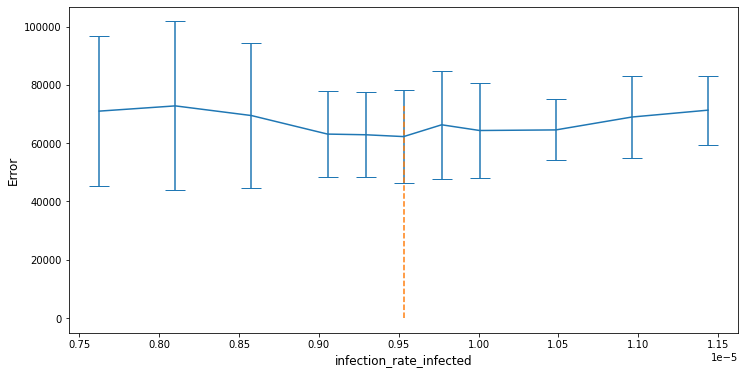

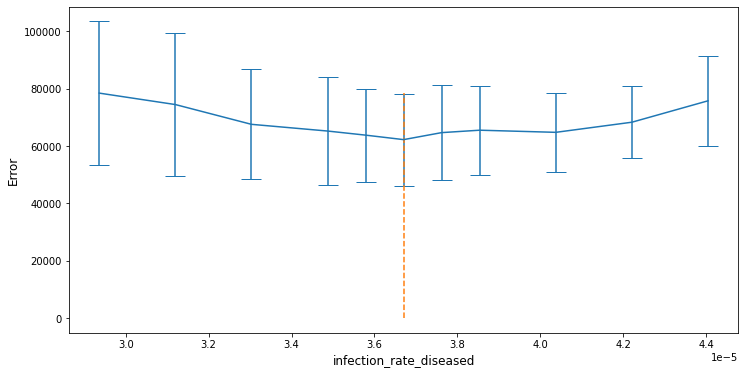

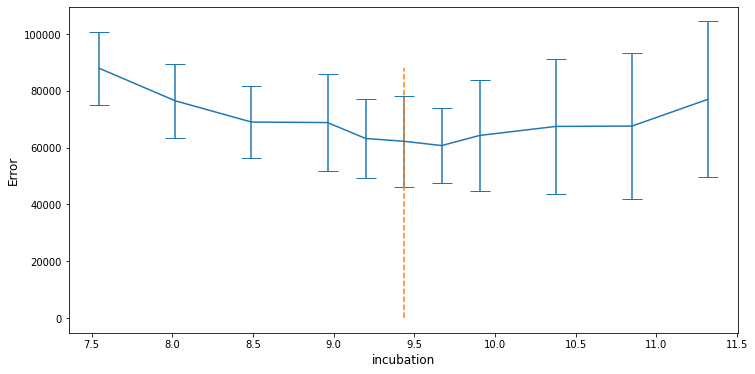

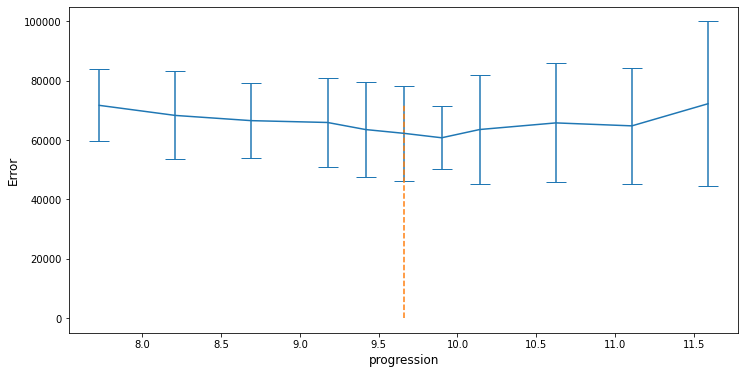

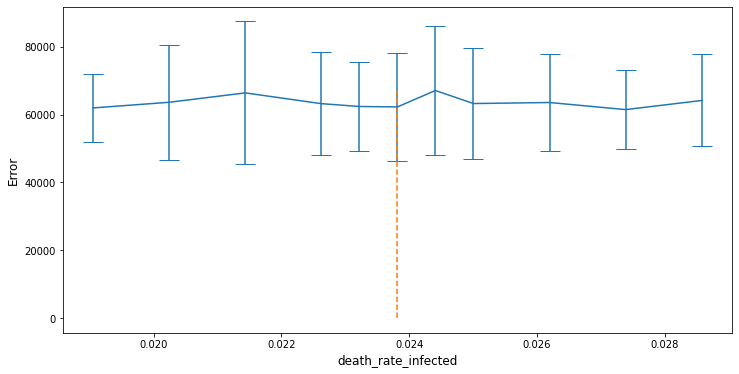

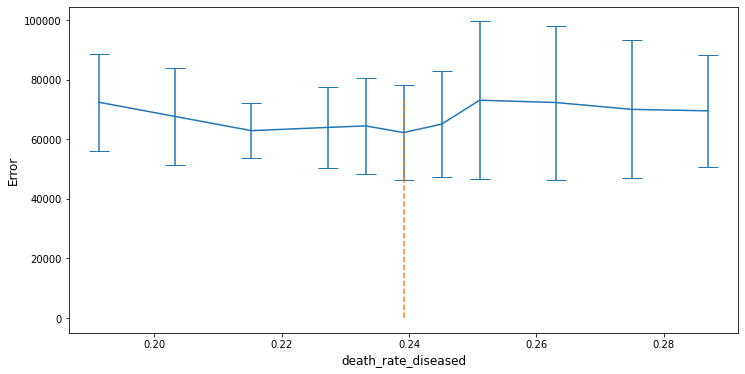

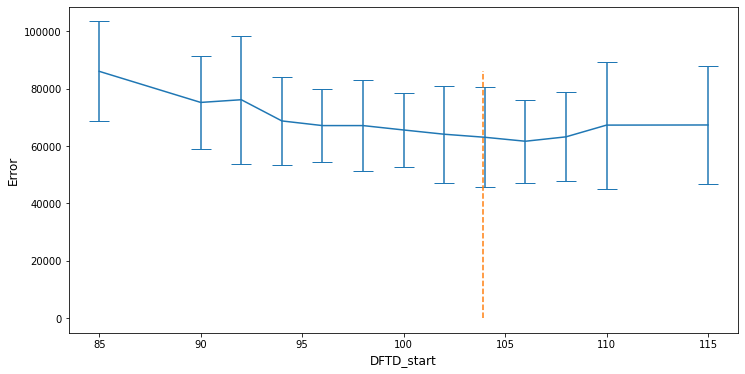

In [20]:
%%time
for k in sweeps.keys():
    plot_sweep(k)


# Publication quality plots

In [21]:
print("Parameter                sweep value     current value")
print("---------                -----------     -------------")
for name in ['infection_rate_infected','infection_rate_diseased',
             'incubation','progression','death_rate_infected',
             'death_rate_diseased','DFTD_start']:
    xvals = numpy.zeros(len(sweeps[name]))
    mvals = numpy.zeros(len(sweeps[name]))
    svals = numpy.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = type_variables[name](v)
        try:
            (m,s) = get_mean_std(c)
            xvals[n]=c[name]
            mvals[n]=m
            svals[n]=s
        except Exception as e:
            print(f"caught e={e} while name={name} ")
    minx=math.inf
    for n in range(len(xvals)):
        if mvals[n] < minx:
            minx=mvals[n]
            minn=n
    #print(n,minx,xvals[minn],mvals[minn])
    print(f"{name} {' '*(23-len(name))} {xvals[minn]} {' '*(15-len(str(xvals[minn])))} {variables[name]}")


Parameter                sweep value     current value
---------                -----------     -------------
infection_rate_infected  9.5308e-06       9.530836628131594e-06
infection_rate_diseased  3.6702e-05       3.6702362283180535e-05
incubation               9.6703           9.434483161520545
progression              9.8998           9.658348217046363
death_rate_infected      0.027386         0.023814006049944304
death_rate_diseased      0.23915          0.23915331103217033
DFTD_start               106.0            103.91242512228831


In [22]:
1/.24 + 19

23.166666666666668

In [23]:
1/variables['death_rate_diseased'] + variables['incubation'] + variables['progression']

23.274249547874554

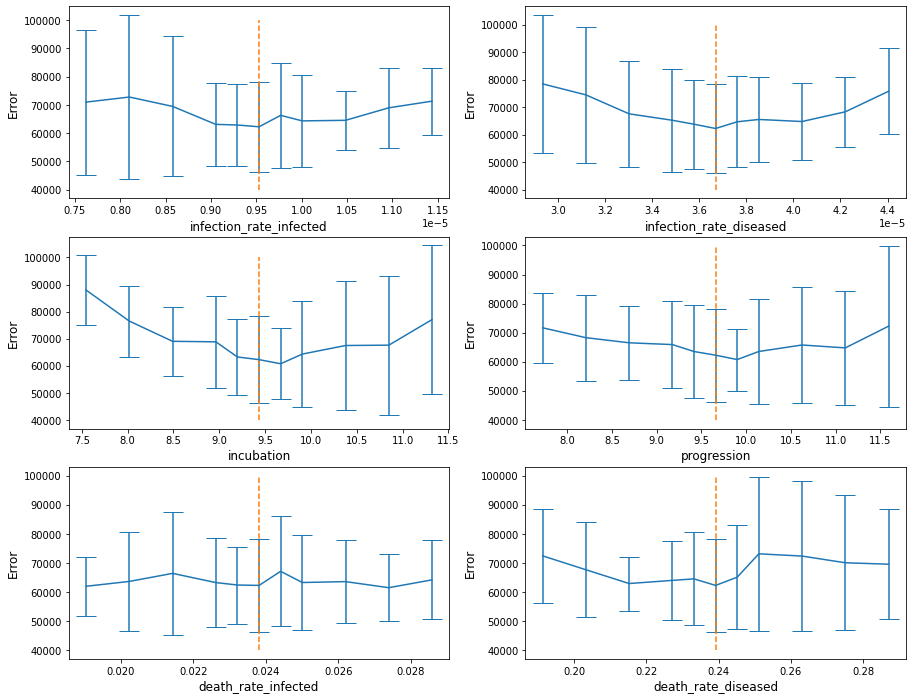

In [24]:
plt.figure(figsize=[15, 12])
pltcnt=1
plot_sweep2('infection_rate_infected',3, 2, pltcnt);pltcnt+=1
plot_sweep2('infection_rate_diseased',3, 2, pltcnt);pltcnt+=1
plot_sweep2('incubation',3, 2, pltcnt);pltcnt+=1
plot_sweep2('progression',3, 2, pltcnt);pltcnt+=1
plot_sweep2('death_rate_infected',3, 2, pltcnt);pltcnt+=1
plot_sweep2('death_rate_diseased',3, 2, pltcnt);pltcnt+=1


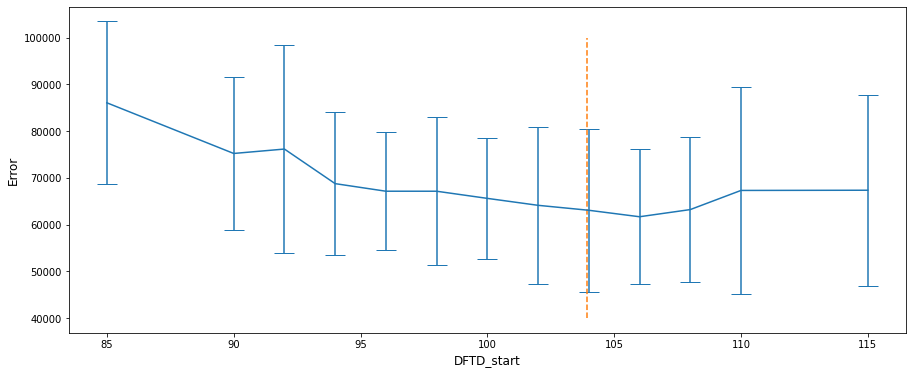

In [25]:
plt.figure(figsize=[15, 6])
plot_sweep2('DFTD_start',1,1,1)

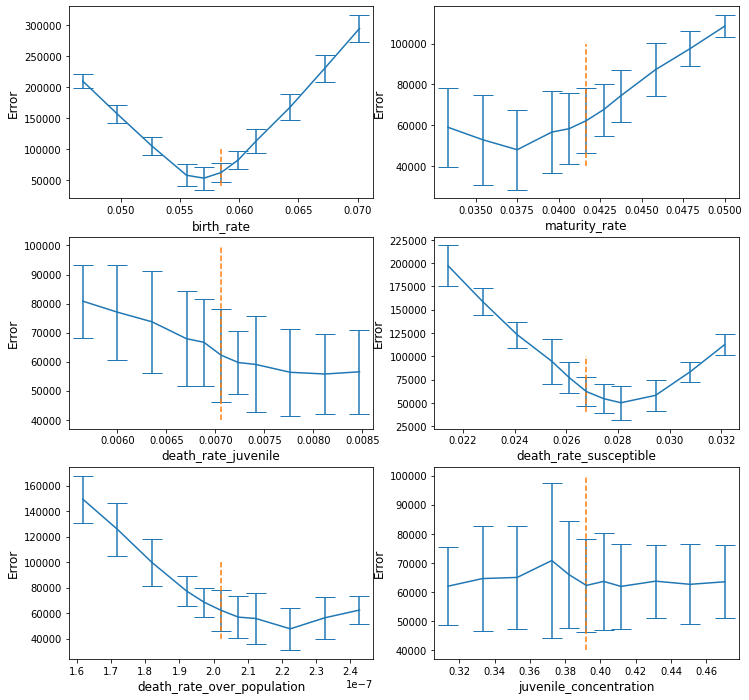

In [26]:
plt.figure(figsize=[12, 12])
pltcnt=1
plot_sweep2('birth_rate',3, 2, pltcnt);pltcnt+=1
plot_sweep2('maturity_rate',3, 2, pltcnt);pltcnt+=1
plot_sweep2('death_rate_juvenile',3, 2, pltcnt);pltcnt+=1
plot_sweep2('death_rate_susceptible',3, 2, pltcnt);pltcnt+=1
plot_sweep2('death_rate_over_population',3, 2, pltcnt);pltcnt+=1
plot_sweep2('juvenile_concentration',3, 2, pltcnt);pltcnt+=1



In [27]:
print("Parameter                sweep value     current value")
print("---------                -----------     -------------")
for name in ['birth_rate','maturity_rate','death_rate_juvenile','death_rate_susceptible',
             'death_rate_over_population','juvenile_concentration']:
    xvals = numpy.zeros(len(sweeps[name]))
    mvals = numpy.zeros(len(sweeps[name]))
    svals = numpy.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = type_variables[name](v)
        try:
            (m,s) = get_mean_std(c)
            xvals[n]=c[name]
            mvals[n]=m
            svals[n]=s
        except Exception as e:
            print(f"caught e={e} while name={name} ")
    minx=math.inf
    for n in range(len(xvals)):
        if mvals[n] < minx:
            minx=mvals[n]
            minn=n
    #print(n,minx,xvals[minn],mvals[minn])
    print(f"{name} {' '*(23-len(name))} {xvals[minn]} {' '*(15-len(str(xvals[minn])))} {variables[name]}")


Parameter                sweep value     current value
---------                -----------     -------------
birth_rate               0.057008         0.05847025317854839
maturity_rate            0.037503         0.04167
death_rate_juvenile      0.0081164        0.007057714094206419
death_rate_susceptible   0.028112         0.026773380233574125
death_rate_over_population  2.2241e-07       2.0219273791008782e-07
juvenile_concentration   0.41166          0.39205283390872614


In [15]:
from Parameter_Sweeps_ssh.DevilsDFTD2StageInfection import DevilsPreVaccination

Running 100 trajectories  37 accepted  complete in 51.35737895965576s
Running 63 trajectories  63 accepted  complete in 38.632787466049194s
CPU times: user 378 ms, sys: 14.5 ms, total: 392 ms
Wall time: 1min 29s


<ipython-input-11-7d4ae86e43cf>:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


{'DFTD_start': 92.77935556132876, 'birth_rate': 0.06752545559096416, 'death_rate_diseased': 0.26652318495948685, 'death_rate_infected': 0.026874850246323214, 'death_rate_juvenile': 0.008626490086993014, 'death_rate_over_population': 2.691054479103682e-07, 'death_rate_susceptible': 0.021134296008419064, 'incubation': 12.172499624073005, 'infection_rate_diseased': 4.417483587945668e-05, 'infection_rate_infected': 7.542254313029466e-06, 'juvenile_concentration': 0.43955619317374217, 'maturity_rate': 0.04000000000000001, 'progression': 11.875637959748653}
L2 = 232928.34 +/-35750.65


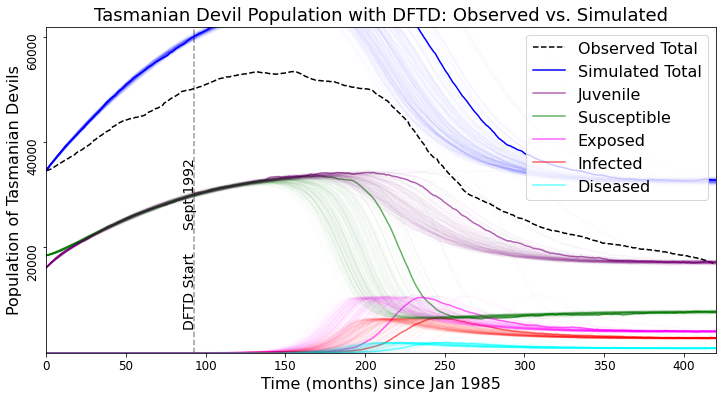

In [16]:
model = DevilsPreVaccination(values=variables)
%time eresults = model.run(number_of_trajectories=100, verbose=True)
plot_eresult(eresults)

Running 100 trajectories  100 accepted  complete in 17.66741704940796s
CPU times: user 212 ms, sys: 8.81 ms, total: 220 ms
Wall time: 17.7 s
{'DFTD_start': 92.77935556132876, 'birth_rate': 0.06752545559096416, 'death_rate_diseased': 0.26652318495948685, 'death_rate_infected': 0.026874850246323214, 'death_rate_juvenile': 0.008626490086993014, 'death_rate_over_population': 2.691054479103682e-07, 'death_rate_susceptible': 0.021134296008419064, 'incubation': 12.172499624073005, 'infection_rate_diseased': 4.417483587945668e-05, 'infection_rate_infected': 7.542254313029466e-06, 'juvenile_concentration': 0.43955619317374217, 'maturity_rate': 0.04000000000000001, 'progression': 11.875637959748653}
L2 = 660300.11 +/-2992.88


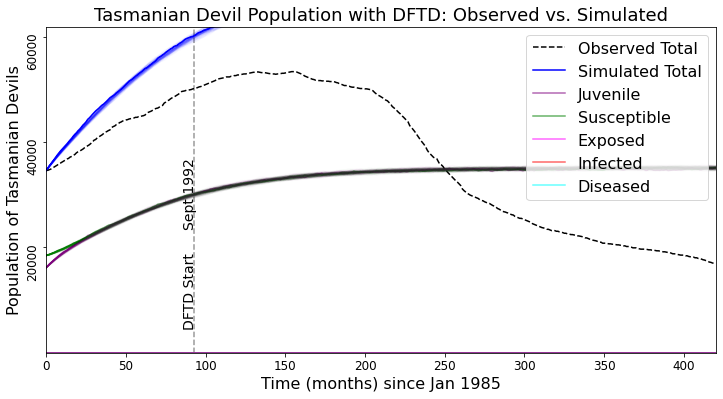

In [17]:
model2 = DevilsPreVaccination(values=variables)
%time eresults2 = model2.run(number_of_trajectories=100, verbose=True, with_DFTD=False)
plot_eresult(eresults2)

In [18]:
final_devil_pop = eresults2[0]['Devils'][-1]

print(f"Number of Devils {final_devil_pop} at simulation end,",
      f"{final_devil_pop/carry_cap*100:.1f}% of target carrying capacity")

Number of Devils 70288.0 at simulation end, 113.6% of target carrying capacity


In [19]:
final_devil_pops = []
for n,r in enumerate(eresults2):
    final_devil_pops.append(r['Devils'][-1])
    
print(f"Number of Devils ={np.average(final_devil_pops):.0f} +/-{np.std(final_devil_pops):.0f} at simulation end,",
      f"{np.average(final_devil_pops)/carry_cap*100:.1f}% of target carrying capacity")
    

Number of Devils =70112 +/-338 at simulation end, 113.3% of target carrying capacity


In [ ]:
raise Exception("Don't run-all past here")

In [ ]:
import pickle

In [ ]:
# with open('Fig3_Fig4-data.p','wb+') as fd:
#     pickle.dump({'variables':variables,
#                  'sweeps':sweeps,
#                  'eresults':eresults,
#                  'eresults2':eresults2,
#                  'mean_std_db':mean_std_db,
#                 },fd)